In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
source("likelihoodFunctionCC.R")
source("TADAaddEvidence.R")
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Running TADA
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])
#count.mu.Data <- cbind(counts[, 4:6], data$mut.rate*mu.frac[2])

########Calculate data.frame and likelihood function
##countData should be a data.frame including all annotation types.
#Each type includes 3 columns: de novo, case and control
#mutData: a data.frame including mutation rates of each type


###Re-write the likelihood function

In [3]:
%%R
logLikelihood <- function(countData, hyperpar, pi0 = 0.06, mutationData,
                          testType = c("dn", "CaseControl", "both"), nCore = 1, combinationType = 1){
    ##Identify how many annotation types
    if (is.numeric(mutationData))
        mutationData <- cbind(mutationData)
    kk <- dim(mutationData)[2]

        ###Choose only de novo (dn), only cc (cc), or both ("both")
        testType <- match.arg(testType)
        
        nGene <- dim(countData)[1]
    dataOut <- cbind(rep(1, nGene), rep(1, nGene))

    logLLKallType <- 0
    
    for (jj in 1:kk){

        ##Extract each annotation
        sIndex <- 3*(jj - 1) + 1
        
        countData.type <- cbind(countData[, c(sIndex, sIndex + 1, sIndex + 2)], mutationData[, jj])

#        print(dim(countData.type))
        
        typeData <- apply(countData.type, 1, function(xRow){
            x <- list(dn = xRow[1],
                    ca = xRow[2], cn = xRow[3], mu = xRow[4])

 #           print(xRow)
                #####Alternative hypothesis
                x.alt.CC <- evidence.alt.CC(x = x, N = N, gamma.mean = hyperpar[3, jj],
                                            beta = hyperpar[4, jj],
                                            rho1 = hyperpar[5, jj], nu1 = hyperpar[6, jj])$total

                x.alt.dn <- dnbinom(x = x$dn, hyperpar[1, jj]*hyperpar[2, jj],
                                   hyperpar[2, jj]/(hyperpar[2, jj] + 2*N$dn*x$mu)) 
                    #evidence.alt.dn(x = xRow[1], N = N$dn, mu = xRow[4],
                     #                       gamma.mean = hyperpar[1, 1], beta = hyperpar[2, 1])

#####Null hypothesis

                x.null.CC <- evidence.null.CC(x = x, N = N, rho0 = hyperpar[7, jj], nu0 = hyperpar[8, jj])$total
                x.null.dn <- dpois(x$dn, 2*N$dn*x$mu) #evidence.null.dn(x = xRow[1], N = N$dn, mu = xRow[4])


            return(c(x.alt.CC, x.alt.dn, x.null.CC, x.null.dn))

        })

        #########Done

        ##############################################
                    ##########Calculate log likelihood
        typeData <- t(typeData)
        
            pH1.dn <- typeData[, 2]
            pH0.dn <- typeData[, 4]

        pH1.cc <- typeData[, 1]
        pH0.cc <- typeData[, 3]
        
        if (testType == "dn"){
            pH1 <- pH1.dn
            pH0 <- pH0.dn
        } 
        if (testType == "CaseControl"){
            pH1 <- pH1.cc
            pH0 <- pH0.cc
        }
        if (testType == "both") {
            pH1 <- pH1.cc*pH1.dn
            pH0 <- pH0.cc*pH0.dn
        }
        
        dataOut[, 1] <- dataOut[, 1]*pH1
        dataOut[, 2] <- dataOut[, 2]*pH0

        
    }

        pH1.all <- pi0*dataOut[, 1]
        pH0.all <- (1 - pi0)*dataOut[, 2]

        pH.all <- pH1.all + pH0.all
        
        logLLK <- sum(log(pH.all[!is.na(pH.all)]))

    return(list(dataOut = dataOut, logLik = logLLK))
}



###Likelihood for de novo LoF only

In [4]:
%%R
piSeq <- seq(0.001, 0.07, 0.002)
library('parallel')

llkout <- lapply(piSeq, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "dn")$logLik)
                 


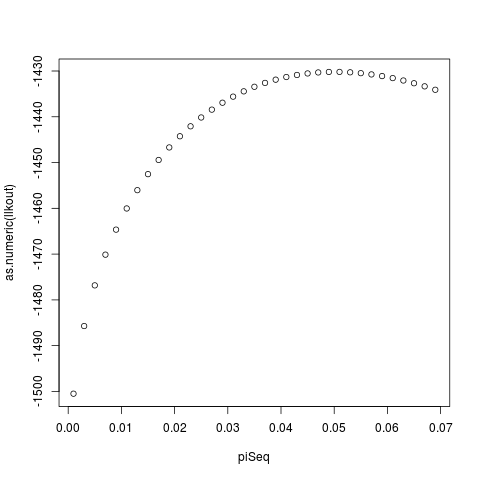

In [5]:
%%R
llkout
plot(piSeq, as.numeric(llkout))



In [6]:
%%R
piSeq <- seq(0.001, 0.07, 0.002)
library('parallel')

mutationData <- cbind(data$mut.rate*mu.frac[1],
                     data$mut.rate*mu.frac[2])

llkout <- lapply(piSeq, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = mutationData, 
                                                   testType = "dn")$logLik)
                 


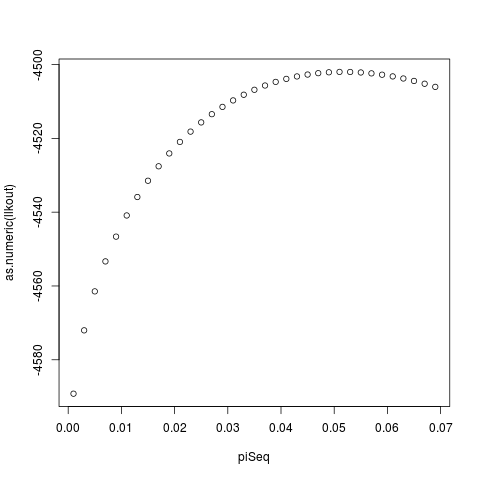

In [7]:
%%R
llkout
plot(piSeq, as.numeric(llkout))



In [8]:
%%R
piSeq.cc <- seq(0.000001, 0.0001, 0.000002)


llkout.cc <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "CaseControl")$logLik)
                 


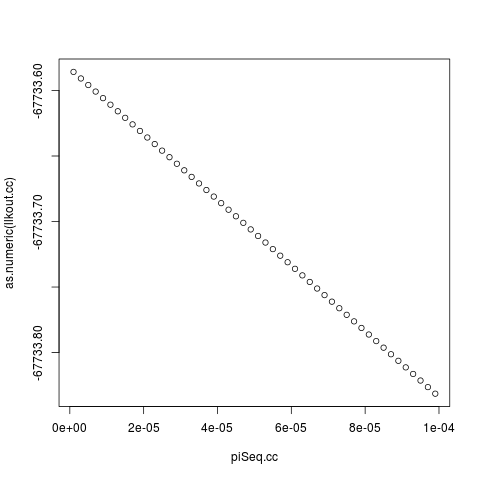

In [9]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###For mis3

In [14]:
%%R
piSeq.cc <- seq(0.000001, 0.03, 0.0002)


llkout.cc <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts[, c(4, 5, 6)], hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[2], 
                                                   testType = "CaseControl")$logLik)
                 


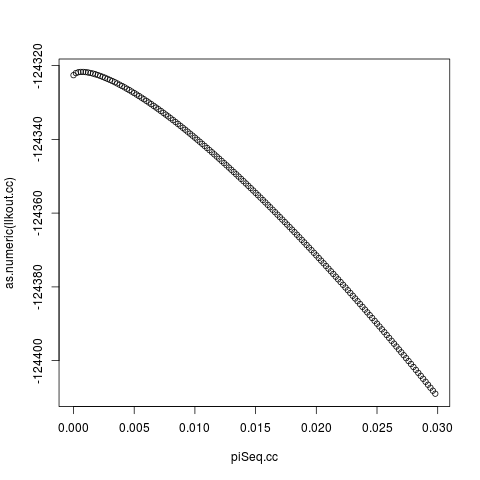

In [15]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###Combine case-control data of two annovation types

In [10]:
%%R
piSeq.cc.both <- seq(0.000001, 0.001, 0.000002)


llkout.cc.both <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = mutationData, 
                                                   testType = "CaseControl")$logLik)
                 


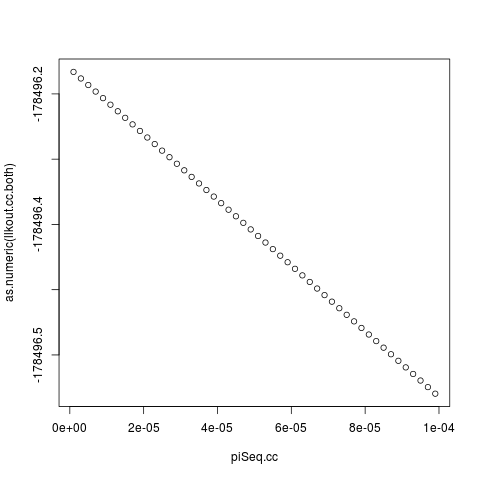

In [13]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc.both))


#Just here
###Cannnot see the optimal point for case-control data, use an analytic way

####Write a function to calculate the optimal values

###Combine case-control data

In [16]:
%%R
library('parallel')
piSeq1 <- seq(0.00001, 0.05, 0.0002)


llkout.cc <- mclapply(piSeq1, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = mutationData, 
                                                        testType = "both")$logLik)
                 



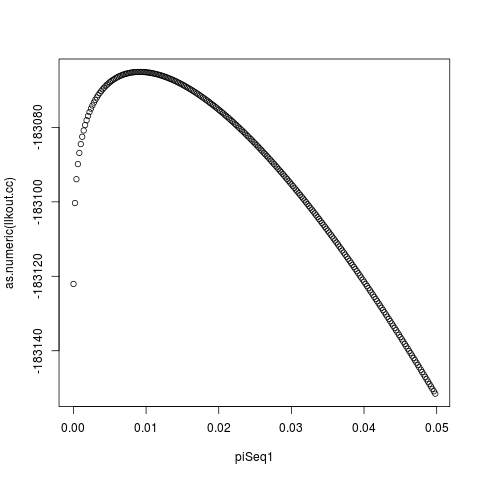

In [17]:
%%R
plot(piSeq1, as.numeric(llkout.cc))

###Write a function to calculate optimal values

In [29]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc <- function(x){

    piX <- x[1]
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, mutationData = mutationData)$logLik
    return(log.All)
}

#R -e "install.packages(c('rjags'), repos='http://cran.rstudio.com/')"

###Optimize to obtain local optimization values for de novo data of LoF and mis3

In [30]:
%%R
library("optimx")
pi.M <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 0.01,   1, 0.01),
               upper = c(1, 100, 5.00, 100, 5.00))



In [31]:
%%R
pi.M

                 p1       p2         p3       p4       p5    value fevals
L-BFGS-B 0.07183842 13.81419 0.04287801 4.547195 4.997559 4492.687     66
         gevals niter convcode kkt1  kkt2  xtimes
L-BFGS-B     66    NA        0 TRUE FALSE 8918.82


###Set a lower limit for gamma.mean

In [49]:
%%R
library("optimx")
pi.M.n <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 1,   1, 1),
               upper = c(1, 100, 5.00, 100, Inf))



In [50]:
%%R

pi.M.n

                 p1      p2 p3     p4 p5    value fevals gevals niter convcode
L-BFGS-B 0.05063322 20.0001  1 5.0002  1 4501.807      5      5    NA        0
         kkt1 kkt2 xtimes
L-BFGS-B TRUE TRUE 648.31


#### => When beta is small => higher likelihood value

In [21]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


In [54]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc.both <- function(x){

    piX <- x[1]
    
    ###De novo
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    
    ###Case-control
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, 
                              testType = "both",
                              mutationData = mutationData)$logLik
    return(log.All)
}



###Test for case-control + de novo data for both LoF + mis3

In [23]:
%%R
library("optimx")
pi.M.both <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 0.01,   1, 0.01,
                        1, 0.01, 1, 0.01),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [24]:
%%R
pi.M.both

                  p1      p2         p3       p4        p5  p6 p7 p8  p9
L-BFGS-B 0.007732048 20.4113 0.01988988 5.437522 0.9675653 2.3  4  1 100
            value fevals gevals niter convcode kkt1  kkt2 xtimes
L-BFGS-B 183050.5     11     11    NA        0 TRUE FALSE   2573


In [25]:
%%R
summary(pi.M.both)

                  p1      p2         p3       p4        p5  p6 p7 p8  p9
L-BFGS-B 0.007732048 20.4113 0.01988988 5.437522 0.9675653 2.3  4  1 100
            value fevals gevals niter convcode kkt1  kkt2 xtimes
L-BFGS-B 183050.5     11     11    NA        0 TRUE FALSE   2573


In [36]:
%%R
pi.M.both$p1

[1] 0.007732048


In [40]:
%%R
xOut <- pi.M.both

est.gamma.mean.dn.lof <- xOut$p2
est.beta.dn.lof <- xOut$p3
est.gamma.mean.dn.mis3 <- xOut$p4
est.beta.dn.mis3 <- xOut$p5

est.gamma.mean.cc.lof <- xOut$p6
est.beta.cc.lof <- xOut$p7
est.gamma.mean.cc.mis3 <- xOut$p8
est.beta.cc.mis3 <- xOut$p9


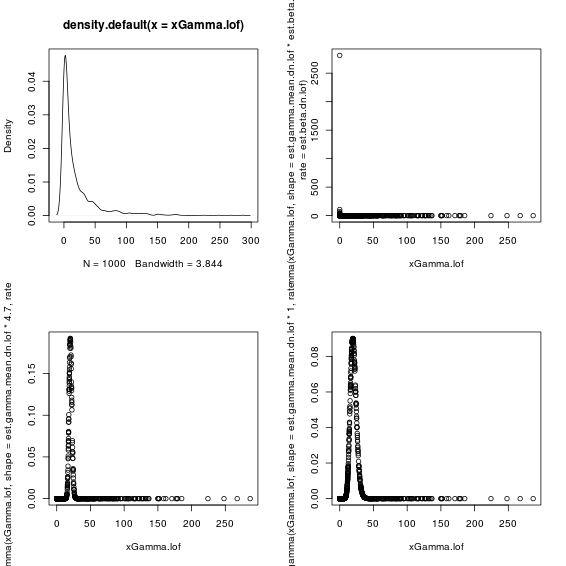

In [48]:
%%R -w 20 -h 20 -u cm
xGamma.lof <- rgamma(1000, shape = est.gamma.mean.dn.lof*est.beta.dn.lof, 
                    rate = est.beta.dn.lof)


par(mfrow = c(2, 2))
plot(density(xGamma.lof))
plot(xGamma.lof, dgamma(xGamma.lof, shape = est.gamma.mean.dn.lof*est.beta.dn.lof, 
                    rate = est.beta.dn.lof))
plot(xGamma.lof, dgamma(xGamma.lof, shape = est.gamma.mean.dn.lof*4.7, 
                    rate = 4.7))
plot(xGamma.lof, dgamma(xGamma.lof, shape = est.gamma.mean.dn.lof*1, 
                    rate = 1))

In [46]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


###Change the lower + upper limitation for (case-control + de-novo) of both LoF + mis3

In [55]:
%%R
piFunc.both

function (x) 
{
    piX <- x[1]
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]
    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3
    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew, 
        pi0 = piX, testType = "both", mutationData = mutationData)$logLik
    return(log.All)
}


In [57]:
%%R
library("optimx")
pi.M.both.n <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 1,   1, 1,
                        1, 1, 1, 1),
               upper = c(1, 
                         100, 5.00, 100, Inf,
                        100, Inf, 100, Inf))



In [52]:
%%R
pi.M.both.n

                 p1       p2 p3       p4       p5  p6 p7 p8  p9    value fevals
L-BFGS-B 0.00651686 29.83633  1 15.45292 1.000007 2.3  4  1 100 183049.4     24
         gevals niter convcode kkt1  kkt2  xtimes
L-BFGS-B     24    NA        0 TRUE FALSE 5382.88


In [61]:
#!gist -p Re_test_all_parameters_inTADA_useProd_inside.ipynb

https://gist.github.com/f89b1829b734f4ae2781


In [63]:
!gist -u https://gist.github.com/f89b1829b734f4ae2781 Re_test_all_parameters_inTADA_useProd_inside.ipynb

https://gist.github.com/f89b1829b734f4ae2781
